<a href="https://colab.research.google.com/github/DoubleCyclone/Neural-Network-From-Scratch/blob/main/notebooks/Neural_Network_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introduction & Setup
As a Machine Learning student (self-proclaimed), I am learning how to build and use various models. In this notebook specifically, I will create my own Neural Network from Scratch with Numpy.

I will be using the [**MNIST**](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset to train the model and run predictions.

Let's import the packages first.

In [251]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

At first I have to load the MNIST datasets and get an idea about their shapes.

In [252]:
# Load the MNIST dataset with the specified transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a DataLoader to load the dataset in batches
loader_train = DataLoader(mnist_train, batch_size=1, shuffle=True)
loader_test = DataLoader(mnist_test, batch_size=1, shuffle=False)

There are 60000 images in the training set and 10000 in the test set. The images are of 28x28 size. Now let's plot a few of the data with their labels as visualization is of utmost importance especially when learning.

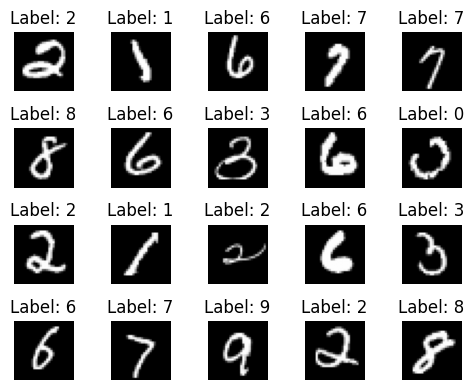

In [253]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(5, 4))

# Flatten to iterate easily
axs = axs.flatten()

# Print the first few images in a row
for i, (image, label) in enumerate(loader_train):
    # Print the first 20 samples
    if i < 20:
        axs[i].imshow(image[0].squeeze(), cmap='gray') # Show the image
        axs[i].set_title(f"Label: {label.item()}") # Set the label as the title
        axs[i].axis('off') # Turn off axis to make the image cleaner
    else:
        break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

What about checking how one example looks in numerical form?

In [254]:
loader_train.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Seems like the background (black) is encoded as 0 and greater than 0 are the foreground (white/whiteish) where it gets lighter the further away it gets from 0.

For our handmade Neural Network, I will set up just one hidden layer. Output node count has to be equal to the class count which is 10 (numbers from 0 to 9). Input node count has to be equal to the image size which is 28 x 28 = 784 pixels.

# 2 - Building Mathematical Components
As activation functions, I will be using **ReLU** (Rectified Linear Unit) for hidden layers as it helps with vanishing gradient problem and **Softmax** for the output layer so that their probabilities' sum will be equal to 1 (100%). Let's start by implementing **ReLU** and plotting it.

In [255]:
# Relu function
def relu(x : float) :
  return np.maximum(0, x)

Let's also create a simple plotting function to easily visualize our implemented functions.

In [256]:
def plot_func(func, x) :
  # plot x versus y (func(x))
  plt.plot(x, [func(val) for val in x])
  plt.xlabel("x")
  plt.ylabel("Function")
  plt.show()

Now let's visualize to check if the function is correct.

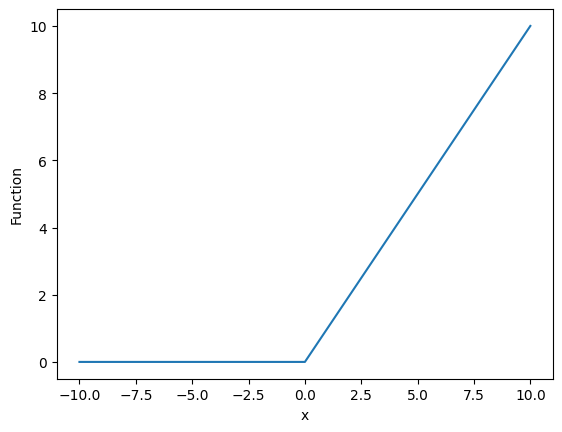

In [257]:
# decide on some x values for plotting
x = [i for i in range(-10, 11, 1)]

plot_func(relu, x)

I will have to implement the derivatives of these functions as they will be needed later on.

In [258]:
def d_relu(x) :
  return x > 0

Visualize this one as well.

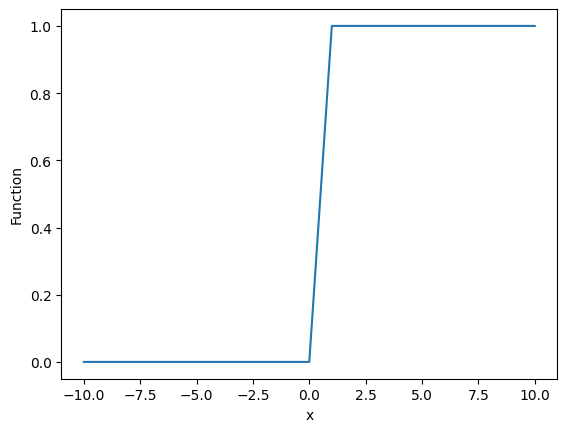

In [259]:
plot_func(d_relu, x)

Now I will implement the **Softmax** function.

In [260]:
def softmax(logits) :
  exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
  return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

In [261]:
# Create a simple vector for testing
vector = [1, 3, 2]

# Test the function
print(softmax(vector))

[0.09003057 0.66524096 0.24472847]


Seems like the softmax function is working as intended as well. For a model to evaluate how much error it has, we need a **Loss Function**. As this is a multiclass classification task, I can use something called a **Categorical Cross-entropy loss**. It measures the difference between the predicted probability distribution and the true one-hot encoded labels, penalizing the model when confidence is low on the correct class. Now let's implement it.

In [262]:
def categorical_cross_entropy(pred_labels, true_labels):
    # Use .shape to handle both single samples and batches
    if pred_labels.shape != true_labels.shape:
        # Reshape labels if they are 1D but predictions are 2D (common in single-sample checks)
        if pred_labels.ndim > true_labels.ndim:
            true_labels = true_labels.reshape(1, -1)
        else:
            print(f"Shape Mismatch: Preds {pred_labels.shape}, Labels {true_labels.shape}")
            return None

    epsilon = 1e-9
    pred_labels = np.clip(pred_labels, epsilon, 1 - epsilon)
    # Sum across the whole batch and average outside, or sum everything here
    return -np.sum(true_labels * np.log(pred_labels))

Now let's test the function. Note that our loss function requires one-hot encoded labels.

In [263]:
true_label = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0] )# Example one-hot encoding for class 4, length 10 for MNIST
preds = softmax(np.random.rand(10)) # Generate 10 random logits for 10 classes

# Has to be 1 (floating point precision problem may make this 0.99999999 or 1.00000002 or similar)
print(np.sum(preds))

print(categorical_cross_entropy(preds, true_label))

1.0
2.2513511753872035


In [264]:
def d_categorical_cross_entropy(pred_labels, true_labels) :
  return pred_labels - true_labels

In [265]:
print(d_categorical_cross_entropy(np.asarray([0.15, 0.4, 0.46]), np.asarray([1, 0, 0])))

[-0.85  0.4   0.46]


Now that our functions are ready, I can start building some matrices so that they form a neural network. For weights, there are a few initialization strategies like **Xavier Initialization** and **He Initialization**. First one is more suitable for layers that use **TANH** and **Sigmoid** activation function whereas the second one is better when paired with **ReLU** activation function.

To decide on the size of our only hidden layer, I will follow a few rule-of-thumb methods:
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

So if I were to follow the second rule, the hidden layer should have 533 (532,6 rounded up) nodes. Now let's build the layers.

In [266]:
# Calculate total nodes on each layer
input_node_count = loader_train.dataset.data.shape[1] * loader_train.dataset.data.shape[2]
output_node_count = len(np.unique(loader_train.dataset.targets.numpy()))
hidden_node_count = np.ceil((input_node_count * 2 / 3) + output_node_count).astype(int)

# Initialize node weights
input_hidden_weights = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
hidden_output_weights = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)

# Initialize node biases
hidden_biases = np.zeros(shape=(hidden_node_count))
output_biases = np.zeros(shape=(output_node_count))

print(f"Input-Hidden Layer weights amount : {input_hidden_weights.shape}")
print(f"Hidden-Output Layer weights amount : {hidden_output_weights.shape}")
print(f"Hidden biases Layer amount : {hidden_biases.shape}")
print(f"Output biases Layer amount : {output_biases.shape}")

Input-Hidden Layer weights amount : (784, 533)
Hidden-Output Layer weights amount : (533, 10)
Hidden biases Layer amount : (533,)
Output biases Layer amount : (10,)


# 3 - Forward Propagation
Now that our layers are ready, it is time to add them together so that they can perform a single forward pass. But before that, I will scale the data so that the range of brightness is reduced from 0-255 to 0-1 as it is infinitely more manageable to work with smaller numbers. I can do this by adding a **Normalization Layer** before any weights or biases are applied. After that, I will also One-Hot encode the labels to be able to compare them with the output probabilities easily.

In [267]:
def apply_normalization(data):
    # Ensure data is a numpy array and reshape to (batch_size, 784)
    if torch.is_tensor(data):
        data = data.numpy()

    # If it's a single image (28x28), reshape to (1, 784)
    # If it's a batch (Batch, 28, 28), reshape to (Batch, 784)
    reshaped_data = data.reshape(data.shape[0] if data.ndim > 2 else 1, -1)
    return reshaped_data / 255

In [268]:
def apply_one_hot_encoding(labels) :
  # Shape the new labels with rows equal to old labels but cols equal to output node count
  oh_encoded = np.empty(shape=(len(labels), output_node_count))
  for i, row in enumerate(oh_encoded) :
    # set all cells to 0 and only the label cell to 1
    oh_encoded[i] = 0
    oh_encoded[i, labels[i]] = 1
  return oh_encoded

In [269]:
def reverse_one_hot_encoding(labels) :
  # Find the index of the 1 in each one-hot encoded vector
  reversed_labels = np.argmax(labels, axis=1)
  return reversed_labels

After this normalization, I will multiply all the neurons in the input layer by the weights that were initialized earlier.

In [270]:
def apply_weights(data, weights):
    return np.dot(data, weights)

Then the biases will be added to the outputs from the weight multiplication.

In [271]:
def apply_biases(data, biases):
    return data + biases

After that, the activation function (ReLU) will be applied to the outputs so that the values are 0 or greater than 0. Lastly, Softmax will be applied so that the logits will be turned into meaningful predictions that sum up to 1. I already implemented ReLU and Softmax earlier so let's just add them all together for a single forward pass.

In [272]:
def single_forward(data, weights_1, biases_1, weights_2, biases_2):
    # Use the updated normalization
    input_layer = apply_normalization(data)

    # np.dot(Batch x 784, 784 x 533) -> Batch x 533
    z1 = apply_biases(apply_weights(input_layer, weights_1), biases_1)
    a1 = relu(z1)

    # np.dot(Batch x 533, 533 x 10) -> Batch x 10
    z2 = apply_biases(apply_weights(a1, weights_2), biases_2)
    a2 = softmax(z2)

    cache = {
        'input': input_layer,
        'z1': z1,
        'a1': a1,
        'z2': z2,
        'a2' : a2
    }
    return a2, cache

Let's test it and see if the outputs make sense.

In [273]:
# Perform a single forward pass
preds, cache = single_forward(loader_train.dataset.data[0].flatten(), input_hidden_weights, hidden_biases, hidden_output_weights, output_biases)

# One-Hot Encode the first label for testing
true_label_one_hot = apply_one_hot_encoding([loader_train.dataset.targets[0].item()])[0]

# Calculate the loss
loss = categorical_cross_entropy(preds, true_label_one_hot)

print(f"Predicted class : {np.argmax(preds)}")
print(f"Prediction values : {preds}")
print(f"Sum of predictions : {preds.sum()}")
print(f"Loss : {loss}")

Predicted class : 6
Prediction values : [[0.11589139 0.12704442 0.09690832 0.10734772 0.08881985 0.12168551
  0.1347039  0.05616606 0.05442222 0.09701061]]
Sum of predictions : 1.0000000000000002
Loss : 2.1063153778651618


As can be seen from the sum and the values themselves, they sum up to 1 which was exactly what I wanted. Note that currently as the model is not being trained at all (only random initialization), its predictions are random.
# 4 - Backward propagation
To be able to train the model, I need to implement something called "**Backward Propagation**" which is the process of calculating how much each weight and bias should change with respect to the current error of the prediction. For this, I need to implement the derivatives of the weights and biases on the layers with respect to the ones in the previous layers. Naturally, we start from the end which is why it is called **Backward propagation**. Last biases' contributions to the loss were directly proportionate as they are added at the end. Fortunately the **Softmax** function and the **Cross-Entropy Loss** functions' derivatives cancel out most calculations, leaving only "predictions - true labels" for us to calculate.

In the next step, I need to calculate how much the weights between the hidden-output layers contribute to the losses so that we can increase/decrease their values accordingly. For this, we need the gradient from the latest step and the input to the layer. With these, we calculate the outer product of them so that we end up with same amount of gradients as the weight count.

Then we propagate error back to the hidden layer on which the ReLU derivative will be applied to check if the neurons were active or inactive.

From there, the same gradient after the ReLU derivative will be applied to the biases on the hidden layer as they are also directly proportionate to the value after the activation.

Lastly, for the weights between the Input-Hidden layer, that same relu derivative applied gradient will be used to calculate the gradients along with the cached input values.

In [274]:
def single_backward(cache, true_labels, weights_2):
    # Determine the number of samples in the current batch
    m = true_labels.shape[0]

    # Gradient at output (predictions - true_labels)
    dL_dz2 = d_categorical_cross_entropy(cache['a2'], true_labels)

    # Gradients for second layer (averaged over batch)
    # Using .T (transpose) and np.dot performs the accumulation and averaging automatically
    dL_dbiases2 = np.sum(dL_dz2, axis=0) / m
    dL_dweights2 = np.dot(cache['a1'].T, dL_dz2) / m

    # Propagate error back to hidden layer
    dL_da1 = np.dot(dL_dz2, weights_2.T)

    # Apply ReLU derivative
    dL_dz1 = dL_da1 * d_relu(cache['z1'])

    # Gradients for first layer (averaged over batch)
    dL_dbiases1 = np.sum(dL_dz1, axis=0) / m
    dL_dweights1 = np.dot(cache['input'].T, dL_dz1) / m

    return {
        'dL_dweights1': dL_dweights1,
        'dL_dbiases1': dL_dbiases1,
        'dL_dweights2': dL_dweights2,
        'dL_dbiases2': dL_dbiases2
    }

In [275]:
# gradients = single_backward(cache, torch.Tensor.numpy(loader_train.dataset.targets[0]), hidden_output_weights)

# 5 - Training Loop
After calculating these gradients, I will update the weights/biases in the network so that the next forward pass will yield better results. As I already have implemented the forward pass and backward propagation, the next thing we need will be deciding on some **Hyperparameters** like **Learning Rate** so that we can amplify how much the gradients affect our model parameters with each pass.

Also, it is often better to run the gradient descent on mini-batches instead of after every sample. This is done by splitting the data into smaller chunks and running gradient descent after each chunk has been processed instead which is computationally cheaper.

I also will split the training set into training and validation sets.

In [276]:
# Divide into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(loader_train.dataset.data, loader_train.dataset.targets, test_size=0.16666, random_state=42)
X_test = loader_test.dataset.data
y_train = apply_one_hot_encoding(y_train)
y_val = apply_one_hot_encoding(y_val)
y_test = apply_one_hot_encoding(loader_test.dataset.targets)

print(f"Shape of training set : {X_train.shape}")
print(f"Shape of validation set : {X_val.shape}")
print(f"Shape of test set : {X_test.shape}")
print(f"Shape of training labels : {y_train.shape}")
print(f"Shape of validation labels : {y_val.shape}")
print(f"Shape of test labels : {y_test.shape}")

Shape of training set : torch.Size([50000, 28, 28])
Shape of validation set : torch.Size([10000, 28, 28])
Shape of test set : torch.Size([10000, 28, 28])
Shape of training labels : (50000, 10)
Shape of validation labels : (10000, 10)
Shape of test labels : (10000, 10)


Now it is time to build the Model class.

In [277]:
class Model() :
  def __init__(self, input_node_count, hidden_node_count, output_node_count) :
    # Initialize node weights
    self.w1 = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
    self.w2 = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)
    # Initialize node biases
    self.b1 = np.zeros(shape=(hidden_node_count))
    self.b2 = np.zeros(shape=(output_node_count))

    self.epoch_losses = []
    self.val_losses = []

    self.accuracy_scores = []
    self.precision_scores = []
    self.recall_scores = []
    self.f1_scores = []
    self.val_accuracy_scores = []
    self.val_precision_scores = []
    self.val_recall_scores = []
    self.val_f1_scores = []

  # Call forward pass
  def __forward(self, data) :
    return single_forward(data, self.w1, self.b1, self.w2, self.b2)

  # Call backward propagation
  def __backward(self, cache, true_labels) :
    return single_backward(cache, true_labels, self.w2)

  # Update weights with respect to the gradients and learning rate
  def __update_weights(self, gradients, learning_rate) :
    self.w1 -= gradients['dL_dweights1'] * learning_rate
    self.b1 -= gradients['dL_dbiases1'] * learning_rate
    self.w2 -= gradients['dL_dweights2'] * learning_rate
    self.b2 -= gradients['dL_dbiases2'] * learning_rate

  def predict(self, X_test, compare = False, true_labels = None):
    # Pass the entire dataset X through the forward pass at once
    pred_probs, _ = self.__forward(X_test)

    # Use axis=1 to find the highest probability for each individual image
    preds = np.argmax(pred_probs, axis=1)

    # Initialize empty metrics dict
    metrics = {}

    # Calculate and store metrics if comparison is turned on
    if compare :
      # Reverse the one hot encoding
      true_labels = reverse_one_hot_encoding(true_labels)
      # Calculate metrics
      metrics['accuracy'] = accuracy_score(true_labels, preds)
      metrics['precision'] = precision_score(true_labels, preds, average='weighted', zero_division=0)
      metrics['recall'] = recall_score(true_labels, preds, average='weighted', zero_division=0)
      metrics['f1'] = f1_score(true_labels, preds, average='weighted', zero_division=0)

    return preds, metrics

  def train(self, epochs, batch_size, learning_rate, X_train, y_train, val = False, X_val = None, y_val = None) :
    # Reset metric lists for a new training run
    self.epoch_losses = []
    self.val_losses = []
    self.accuracy_scores = []
    self.precision_scores = []
    self.recall_scores = []
    self.f1_scores = []
    self.val_accuracy_scores = []
    self.val_precision_scores = []
    self.val_recall_scores = []
    self.val_f1_scores = []

    # Convert one-hot encoded true labels to class labels for metric calculation (done once)
    true_labels_train_classes = reverse_one_hot_encoding(y_train)
    if val:
      true_labels_val_classes = reverse_one_hot_encoding(y_val)

    # For every epoch
    for epoch in range(epochs):
      X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
      num_batches = len(X_train_shuffled) // batch_size
      epoch_loss = 0

      for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = batch_start + batch_size

        X_batch = X_train_shuffled[batch_start:batch_end]
        y_batch = y_train_shuffled[batch_start:batch_end]

        predictions, cache = self.__forward(X_batch)

        # Divide by batch_size here to get the average loss for this batch
        batch_loss = categorical_cross_entropy(predictions, y_batch) / batch_size
        epoch_loss += batch_loss

        gradients = self.__backward(cache, y_batch)
        self.__update_weights(gradients, learning_rate)

      # IMPORTANT: Append to epoch_losses OUTSIDE the batch loop
      self.epoch_losses.append(epoch_loss / num_batches)

      # Training Metrics
      predicted_labels_train, _ = self.predict(X_train)
      self.accuracy_scores.append(accuracy_score(true_labels_train_classes, predicted_labels_train))
      # Use average='weighted' for multiclass classification
      self.precision_scores.append(precision_score(true_labels_train_classes, predicted_labels_train, average='weighted', zero_division=0))
      self.recall_scores.append(recall_score(true_labels_train_classes, predicted_labels_train, average='weighted', zero_division=0))
      self.f1_scores.append(f1_score(true_labels_train_classes, predicted_labels_train, average='weighted', zero_division=0))


      # Track validation loss
      val_loss = 0

      # Validation Loop
      if val:
        val_predictions, _ = self.__forward(X_val)
        # Calculate total validation loss and divide by the number of validation samples
        self.val_losses.append(categorical_cross_entropy(val_predictions, y_val) / X_val.shape[0])

        # Calculate and store validation metrics for the entire X_val
        predicted_labels_val, _ = self.predict(X_val)
        self.val_accuracy_scores.append(accuracy_score(true_labels_val_classes, predicted_labels_val))
        self.val_precision_scores.append(precision_score(true_labels_val_classes, predicted_labels_val, average='weighted', zero_division=0))
        self.val_recall_scores.append(recall_score(true_labels_val_classes, predicted_labels_val, average='weighted', zero_division=0))
        self.val_f1_scores.append(f1_score(true_labels_val_classes, predicted_labels_val, average='weighted', zero_division=0))

        # Print validation progress
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {self.epoch_losses[epoch]:.4f}, Train Acc: {self.accuracy_scores[epoch]:.4f}, Train Pre: {self.precision_scores[epoch]:.4f}, Train Rec: {self.recall_scores[epoch]:.4f}, Train F1: {self.f1_scores[epoch]:.4f}, Val Loss: {self.val_losses[epoch]:.4f}, Val Acc: {self.val_accuracy_scores[epoch]:.4f}, Val Pre: {self.val_precision_scores[epoch]:.4f}, Val Rec: {self.val_recall_scores[epoch]:.4f}, Val F1: {self.val_f1_scores[epoch]:.4f}")
      else :
        # Print training progress
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {self.epoch_losses[epoch]:.4f}, Train Acc: {self.accuracy_scores[epoch]:.4f}, Train Pre: {self.precision_scores[epoch]:.4f}, Train Rec: {self.recall_scores[epoch]:.4f}, Train F1: {self.f1_scores[epoch]:.4f}")

# 6 - Training and Evaluation
Now that our model class is ready with its training function. It is time to train it and see how it performs.

In [278]:
model_np = Model(input_node_count, hidden_node_count, output_node_count)

model_np.train(10, 64, 0.1, X_train, y_train, True, X_val, y_val)

Epoch 1/10, Train Loss: 0.3668, Train Acc: 0.9361, Train Pre: 0.9369, Train Rec: 0.9361, Train F1: 0.9361, Val Loss: 0.2335, Val Acc: 0.9339, Val Pre: 0.9346, Val Rec: 0.9339, Val F1: 0.9339
Epoch 2/10, Train Loss: 0.1967, Train Acc: 0.9563, Train Pre: 0.9564, Train Rec: 0.9563, Train F1: 0.9562, Val Loss: 0.1713, Val Acc: 0.9504, Val Pre: 0.9507, Val Rec: 0.9504, Val F1: 0.9503
Epoch 3/10, Train Loss: 0.1467, Train Acc: 0.9656, Train Pre: 0.9657, Train Rec: 0.9656, Train F1: 0.9655, Val Loss: 0.1426, Val Acc: 0.9590, Val Pre: 0.9591, Val Rec: 0.9590, Val F1: 0.9589
Epoch 4/10, Train Loss: 0.1173, Train Acc: 0.9726, Train Pre: 0.9726, Train Rec: 0.9726, Train F1: 0.9725, Val Loss: 0.1217, Val Acc: 0.9648, Val Pre: 0.9648, Val Rec: 0.9648, Val F1: 0.9648
Epoch 5/10, Train Loss: 0.0979, Train Acc: 0.9780, Train Pre: 0.9781, Train Rec: 0.9780, Train F1: 0.9780, Val Loss: 0.1098, Val Acc: 0.9685, Val Pre: 0.9686, Val Rec: 0.9685, Val F1: 0.9685
Epoch 6/10, Train Loss: 0.0830, Train Acc: 0.

Our model's performance on the validaion set is expectedly worse than the one on the training set but it is definitely comparable which is great news. Now for a real evaluation I have to test it on the held-out test set which we haven't used before. For this I just have to call the predict function of the model class and visualize its predictions along with a few records from the test dataset loader.

It should be noted that the model has better validation loss at first than its train loss because the first validation loop is done after the first training loop where the model already has learnt significantly, boosting the performance on the validation.

In [279]:
test_preds, metrics = model_np.predict(X_test, True, y_test)

for key, value in metrics.items() :
  print(f"{key} : {value:.4f}")

accuracy : 0.9769
precision : 0.9769
recall : 0.9769
f1 : 0.9769


Performance looks great even on the test data. Now let's visualize some predictions against the input images to reinforce the observations.

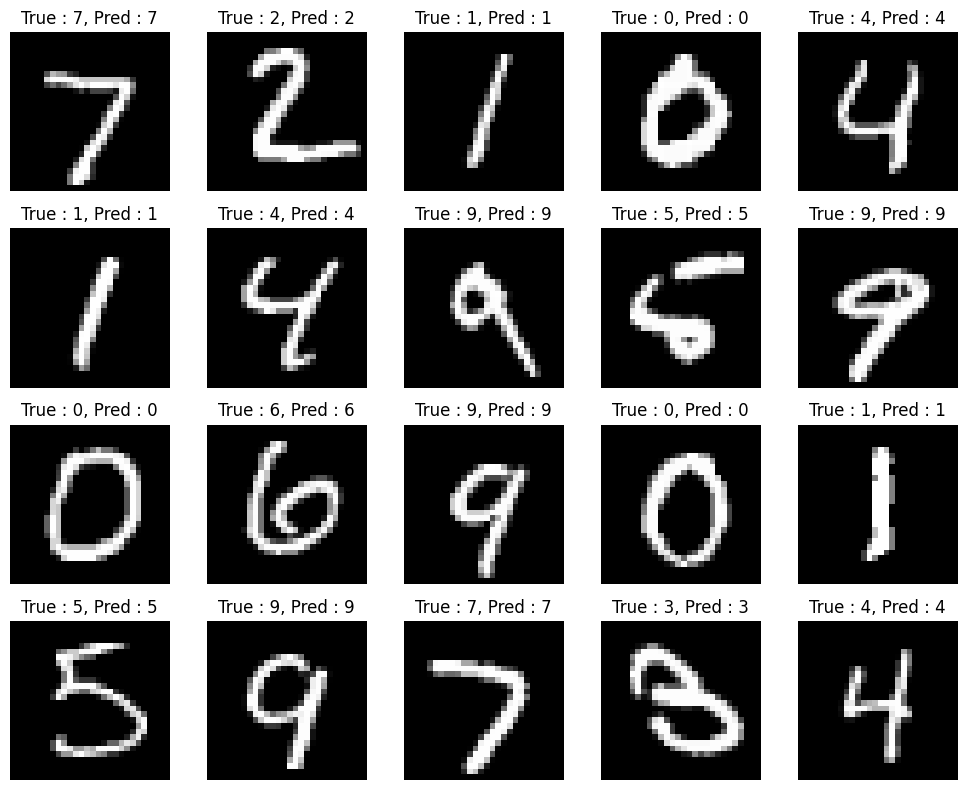

In [280]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(10, 8))

# Flatten to iterate easily
axs = axs.flatten()

# Print the first few images in a row
for i, (image, label) in enumerate(loader_test):
    # Print the first 20 samples
    if i < 20:
        axs[i].imshow(image[0].squeeze(), cmap='gray') # Show the image
        axs[i].set_title(f"True : {label.item()}, Pred : {test_preds[i]}") # Set the label and prediction as the title
        axs[i].axis('off') # Turn off axis to make the image cleaner
    else:
        break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

First 20 records' predictions look really good. Now let's find the failed predictions and visualize them instead.

Total incorrect predictions : 231
Count of incorrect predictions for class 0 : 10
Count of incorrect predictions for class 1 : 16
Count of incorrect predictions for class 2 : 23
Count of incorrect predictions for class 3 : 18
Count of incorrect predictions for class 4 : 18
Count of incorrect predictions for class 5 : 24
Count of incorrect predictions for class 6 : 24
Count of incorrect predictions for class 7 : 31
Count of incorrect predictions for class 8 : 30
Count of incorrect predictions for class 9 : 37


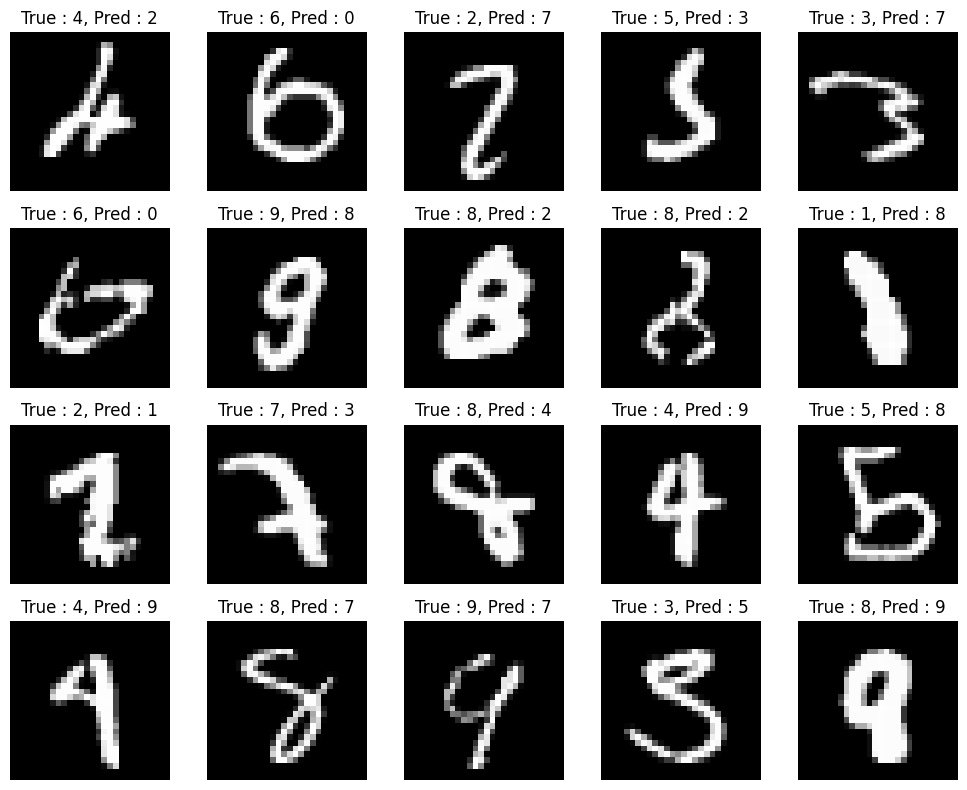

In [281]:
# Get incorrect prediction count
test_labels_np = loader_test.dataset.targets.numpy()
print(f"Total incorrect predictions : {np.not_equal(test_labels_np, test_preds).sum()}")

# Count incorrect predictions for each class
incorrect_counts_per_class = np.zeros(output_node_count, dtype=int)
for i in range(len(test_labels_np)):
    true_label = test_labels_np[i]
    predicted_label = test_preds[i]
    if true_label != predicted_label:
        incorrect_counts_per_class[true_label] += 1

for i, count in enumerate(incorrect_counts_per_class):
    print(f"Count of incorrect predictions for class {i} : {count}")

# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(10, 8))

# Flatten to iterate easily
axs = axs.flatten()

# keep failed prediction count
failed_count = 0

# For every test example
for i, (image, label) in enumerate(loader_test):
  # Plot if true label and predicted label is different
  if label.item() != test_preds[i]:
    axs[failed_count].imshow(image[0].squeeze(), cmap='gray') # Show the image
    axs[failed_count].set_title(f"True : {label.item()}, Pred : {test_preds[i]}") # Set the label and prediction as the title
    axs[failed_count].axis('off') # Turn off axis to make the image cleaner
    failed_count += 1
    # Plot just the first 20
    if failed_count > 19 :
      break;

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

From the incorrect prediction counts per class, it can be inferred that numbers with circles are more prone to guess incorrectly and numbers with distinct shapes (unique to them) are easier for our model to predict. Lastly, let's create a confusion matrix to automatically create a better visualization than the earlier manual incorrect prediction counts.

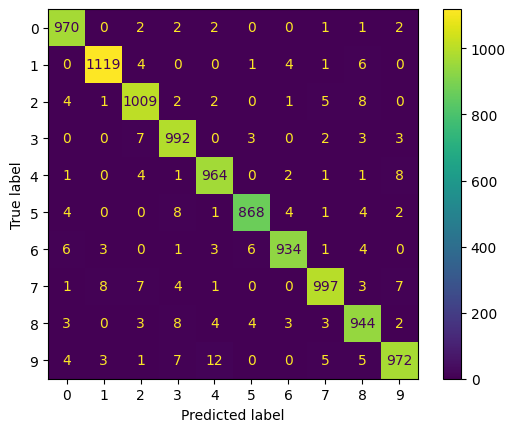

In [282]:
# Create confusion matrix and display it
cm = confusion_matrix(reverse_one_hot_encoding(y_test), test_preds, labels=np.arange(output_node_count))
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(output_node_count))
disp.plot()
plt.show()

Once again it can be seen that our model predicts correctly most of the time.
# 7 - PyTorch Comparison
Finally, my job with the handmade Neural Network is done. This means that I can just use some Python packages (which conveniently make the job a LOT easier for everybody) to create an identical model and compare their performances.

In [292]:
class Model_Torch(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_node_count, hidden_node_count),
      nn.ReLU(),
      nn.Linear(hidden_node_count, output_node_count)
    )

  def forward(self, X) :
    return self.model(X)

After building our model, let's initialize other required components like the loss function.

In [305]:
# Select the device the model will run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Determine batch size
batch_size = 64

# Initialize the model
model_torch = Model_Torch().to(device)

# Initialize Loss Function
loss_fn = nn.CrossEntropyLoss()

# Initialize loaders
transform = transforms.ToTensor()

# Split the full training data into train and validation sets
train_subset, val_subset = random_split(mnist_train, [50000, 10000])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = optim.SGD(model_torch.parameters(), lr=0.1)

The reason why I initialized Train DataLoader with shuffle on and others off is to prevent the model from learning order bias. Shuffling is not needed in validation or test sets as the model won't be learning from them anyway. They are there for evaluation within training and while predicting after the training.

In [309]:
# Number of epochs the model will train for
num_epochs = 10

# Store training epoch losses
epoch_losses = []

# For every epoch
for epoch in range(num_epochs) :
  # reset epoch loss
  epoch_loss = 0

  # For every batch
  for batch_idx, (x, y) in enumerate(train_loader) :
    # Move the tensors to the selected device
    x, y = x.to(), y.to(device)

    # Run forward pass
    logits = model_torch.forward(x)

    # Calculate losses
    loss = loss_fn(logits, y)
    epoch_loss += loss

    # Reset gradients
    optimizer.zero_grad()

    # Perform Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

  # Calculate epoch loss by dividing total loss by the number of batches
  epoch_loss = epoch_loss / (len(train_loader))

  print(f"Epoch {epoch + 1} loss : {epoch_loss:.5f}")

Epoch 1 loss : 0.45684
Epoch 2 loss : 0.23247
Epoch 3 loss : 0.17382
Epoch 4 loss : 0.13777
Epoch 5 loss : 0.11399
Epoch 6 loss : 0.09632
Epoch 7 loss : 0.08335
Epoch 8 loss : 0.07308
Epoch 9 loss : 0.06465
Epoch 10 loss : 0.05766
